## Imports and Initialisations

In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from transformers import AutoFeatureExtractor, ASTForAudioClassification

import warnings
warnings.filterwarnings("ignore")


from google.colab import drive

drive.mount('/content/drive/')


BASE_DATA_PATH = '/content/drive/MyDrive/Freelance/ESC_50/data'
BASE_MODEL_PATH = '/content/drive/MyDrive/Freelance/ESC_50/models'
PRETRAINED_MODEL = 'MIT/ast-finetuned-audioset-10-10-0.4593'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive/


## Data

In [3]:
"""
  * Uncomment and Run this once when you need to prepare the train-test split.
  * Remeber to comment this again after running it.
"""


# from sklearn.model_selection import train_test_split

# train_indices = []
# test_indices = []

# df = pd.read_csv(os.path.join(BASE_DATA_PATH,'ESC-50-master/meta/esc50.csv'))

# # Loop through each fold (1 to 5)
# for fold in range(1, 6):
#     # Get the rows for the current fold
#     fold_data = df[df['fold'] == fold]

#     # Split the fold data into train and test sets (80% train, 20% test)
#     train_, test_ = train_test_split(fold_data, test_size=0.2, random_state=42)

#     # Collect the indices for training and testing
#     train_indices.extend(train_.index)
#     test_indices.extend(test_.index)

# train_df = df.loc[train_indices]
# test_df = df.loc[test_indices]
# print("Train",train_df.shape, "Test", test_df.shape)

# train_df.to_csv(os.path.join(BASE_DATA_PATH,'ESC-50-master/meta/train.csv'), index=False)
# test_df.to_csv(os.path.join(BASE_DATA_PATH,'ESC-50-master/meta/test.csv'), index=False)

'\n  * Uncomment and Run this once when you need to prepare the train-test split.\n  * Remeber to comment this again after running it.\n'

In [16]:
class ESCDataset(Dataset):
    def __init__(self, dataframe, fold=None, esc_10=False):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with 'filename' and 'target' columns
            fold (int, optional): The fold number to filter data (default: None)
            esc_10 (bool, optional): Flag to filter and map targets to 0-9 range for ESC-10 dataset (default: False)
        """
        if fold:
            self.dataframe = dataframe[dataframe['fold'] == fold]
        else:
            self.dataframe = dataframe

        if esc_10:
            # Filter for ESC-10 classes and map them to 0-9 range
            self.dataframe = self.dataframe[self.dataframe['esc10']]
            self.target_mapping = {old_target: new_target for new_target, old_target in enumerate(sorted(self.dataframe['target'].unique()))}
            self.target_labels = {target: self.dataframe[self.dataframe['target']==target]['category'].iloc[0] for target in self.target_mapping.keys()}
            # Create inverse mapping for ESC-10
            self.inverse_target_mapping = {v: self.target_labels[k] for k, v in self.target_mapping.items()}
        else:
            # Create inverse mapping for ESC-50
            self.target_mapping = {old_target: new_target for new_target, old_target in enumerate(sorted(self.dataframe['target'].unique()))}
            self.target_labels = {target: self.dataframe[self.dataframe['target']==target]['category'].iloc[0] for target in self.target_mapping.keys()}

            self.inverse_target_mapping = {v: self.target_labels[k] for k, v in self.target_mapping.items()}

        self.feature_extractor = AutoFeatureExtractor.from_pretrained(PRETRAINED_MODEL)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Load the audio file from the path
        audio_path = self.dataframe.iloc[idx]['filename']
        file = os.path.join(BASE_DATA_PATH, 'ESC-50-master/audio', audio_path)
        waveform, sample_rate = torchaudio.load(file)
        resampler = T.Resample(orig_freq=sample_rate, new_freq=16_000)
        waveform_resampled = resampler(waveform)

        # Extract features using the feature extractor
        inputs = self.feature_extractor(waveform_resampled.squeeze(0), sampling_rate=16_000, return_tensors="pt",
                                        mean=-7.2108297, std=18.78574, return_attention_mask=True, batch_first=True)

        inputs['input_values'] = inputs['input_values'].squeeze(0)

        # Get the target label
        target = self.dataframe.iloc[idx]['target']

        if hasattr(self, 'target_mapping'):
            # Apply target mapping if esc_10 is True
            target = self.target_mapping[target]

        return inputs, target

    def sanity(self):
        print("Number of Entries:", self.dataframe.shape[0])
        print("Number of Classes:", self.dataframe['target'].nunique())
        # print("Number of Entries per Class:")
        # for target in self.dataframe['target'].unique():
        #   print("\t",target, self.dataframe[self.dataframe['target'] == target].shape[0])

        print("Number of Folds:", self.dataframe['fold'].nunique())
        print("Number of Entries per Fold:")
        for fold in self.dataframe['fold'].unique():
            print("\t", fold, self.dataframe[self.dataframe['fold'] == fold].shape[0])

    def get_inverse_target_mapping(self):
        """
        Returns the inverse target mapping for the dataset.
        """
        return self.inverse_target_mapping


In [12]:
def get_dataloaders(esc_10,train_batch_size = 16, test_batch_size=8, train_shuffle=True, test_shuffle=False, num_workers=2,use_aug=False):
  if use_aug:
    train_df = pd.read_csv(os.path.join(BASE_DATA_PATH,'ESC-50-master/meta/train_aug.csv'))
  else:
    train_df = pd.read_csv(os.path.join(BASE_DATA_PATH,'ESC-50-master/meta/train.csv'))
  test_df = pd.read_csv(os.path.join(BASE_DATA_PATH,'ESC-50-master/meta/test.csv'))

  train_dataset = ESCDataset(train_df,esc_10=esc_10)
  test_dataset = ESCDataset(test_df,esc_10=esc_10)

  print("Train Data Insights")
  train_dataset.sanity()
  print("\nTest Data Insights")
  test_dataset.sanity()

  # Create DataLoader for training and testing datasets
  train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=train_shuffle, num_workers=num_workers)
  test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=test_shuffle, num_workers=num_workers)
  return train_loader, test_loader, test_dataset.get_inverse_target_mapping()

## Model

In [6]:
class ESC_AST(nn.Module):
    def __init__(self, num_classes=50):
        super(ESC_AST, self).__init__()
        self.ast_model = ASTForAudioClassification.from_pretrained(PRETRAINED_MODEL, attn_implementation="sdpa")

        # Freeze all parameters
        for param in self.ast_model.parameters():
            param.requires_grad = False

        for i in range(8, 12):
            for param in self.ast_model.audio_spectrogram_transformer.encoder.layer[i].parameters():
                param.requires_grad = True

        # Unfreeze classifier parameters
        for param in self.ast_model.classifier.parameters():
            param.requires_grad = True

        self.fc1 = nn.Linear(527, num_classes)

    def forward(self, inputs):
        logits = self.ast_model(**inputs).logits
        x = self.fc1(logits)
        return x

    def load_model(self, checkpoint_path):
        """
        Load pretrained weights from a .pt file into the model.
        """
        # Load the model state_dict from checkpoint
        checkpoint = torch.load(checkpoint_path, map_location='cpu')  # Adjust 'cpu' to 'cuda' if needed
        self.load_state_dict(checkpoint)
        print("Model weights loaded successfully from:", checkpoint_path)


## Training & Testing

In [9]:
def train(model,train_loader,test_loader,optimizer,criterion,scheduler,epochs,device='cpu',save_best_model=False,model_path=None):
  if save_best_model:
    assert model_path is not None, "model_path must be provided if save_best_model is True"

  best_accuracy = 0.0
  best_epoch = 0
  for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Variable to keep track of correct predictions in training
    total_train = 0  # Total number of samples in training

    # Wrap the training data loader with tqdm for progress bar
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", ncols=100)

    # Training phase
    for inputs, targets in train_bar:
        # Move data to GPU if available
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Zero out gradients from previous step

        # Forward pass
        outputs = model(inputs)  # Model returns logits

        # Compute loss
        loss = criterion(outputs, targets)
        running_loss += loss.item()  # Accumulate the loss for logging

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()  # Update the model parameters

        # Update the progress bar with the current loss
        train_bar.set_postfix(loss=running_loss/len(train_bar), refresh=True)

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")

    if save_best_model:
      accuracy = test(model,test_loader,device)
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_epoch = epoch + 1
          torch.save(model.state_dict(), model_path)  # Save model weights
          print(f"Best model saved at epoch {best_epoch} with accuracy: {best_accuracy * 100:.2f}%")

    scheduler.step()

def test(model, data_loader, inverse_map=None, device='cpu', testMode=False, plot=False):
    # Validation phase (evaluate on the test set)
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []
    all_probs = []  # To store probabilities for ROC AUC

    # Wrap the test data loader with tqdm for progress bar
    test_bar = tqdm(data_loader, desc=f"Testing", ncols=100)

    with torch.no_grad():  # Disable gradient computation during evaluation
        for inputs, targets in test_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass (get model predictions and probabilities)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest logit

            # Store predictions and true targets
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Store probabilities for ROC AUC calculation
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

            # Update progress bar
            test_bar.set_postfix({"accuracy": "Calculating..."}, refresh=True)

    # Calculate accuracy on the test set
    accuracy = accuracy_score(all_targets, all_preds)
    print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

    if testMode:
        # Precision, Recall, and F1 Score
        precision = precision_score(all_targets, all_preds, average='weighted')
        recall = recall_score(all_targets, all_preds, average='weighted')
        f1 = f1_score(all_targets, all_preds, average='weighted')

        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")

        # ROC AUC (Area Under Curve) - Multi-Class Handling
        if len(np.unique(all_targets)) > 1:  # Only calculate ROC AUC if there are multiple classes
            try:
                # Compute AUC for multi-class classification using one-vs-rest
                roc_auc = roc_auc_score(all_targets, all_probs, multi_class='ovr', average='weighted')
                print(f"ROC AUC: {roc_auc:.2f}")
            except ValueError:
                print("ROC AUC calculation failed, possibly due to single class in the test set.")
                roc_auc = None
        else:
            print("ROC AUC cannot be computed with a single class.")

        # Get inverse target mapping if available
        inverse_mapping = inverse_map # Assuming model has this method

        cm = confusion_matrix(all_targets, all_preds)
        print("\nConfusion Matrix:")

        # Replace class indices with the original class labels
        cm_labels = [inverse_mapping[i] for i in np.unique(all_targets)]  # Get original class names
        cm_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

        # Calculate per-class precision and recall
        per_class_precision = precision_score(all_targets, all_preds, average=None)
        per_class_recall = recall_score(all_targets, all_preds, average=None)

        print("\nClasswise Analysis:")
        for i, class_id in enumerate(np.unique(all_targets)):
            # Use the inverse target mapping for class names
            class_name = inverse_mapping[class_id]
            print(f"Class {class_name} - Precision: {per_class_precision[i]:.2f}, Recall: {per_class_recall[i]:.2f}")

        # Plot ROC curve
        if plot:
            plot_roc_curve(all_targets, all_probs, num_classes=len(np.unique(all_targets)))

    return accuracy


def plot_roc_curve(all_targets, all_probs, num_classes):
    """
    Function to plot ROC curve and compute AUC for multi-class classification.
    """
    plt.figure(figsize=(10, 8))

    # Loop through each class
    for i in range(num_classes):
        # Calculate ROC curve for each class (One-vs-Rest)
        fpr, tpr, _ = roc_curve(all_targets, np.array(all_probs)[:, i], pos_label=i)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for this class
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Plot random classifier (diagonal line)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
    plt.legend(loc='lower right')
    plt.show()


## Main

In [8]:
DEVICE

device(type='cuda')

In [1]:
ESC_10 = True #Keep it False for using ESC50 Dataset
train_loader, test_loader,_ = get_dataloaders(ESC_10)
model = ESC_AST(num_classes=10 if ESC_10 else 50)
model.to(DEVICE)
weight_decay = 0.01  # Regularization strength (you can experiment with this value)
optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

# Learning rate scheduler: Decay by a factor of 0.5 every 3 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
epochs = 20

params = {
    'model': model,
    'train_loader': train_loader,
    'test_loader': test_loader,
    'optimizer': optimizer,
    'criterion': criterion,
    'scheduler': scheduler,
    'epochs': epochs,
    'device': DEVICE,
    'save_best_model': True,
    'model_path': os.path.join(BASE_MODEL_PATH,'trained_ast_esc10.pth' if ESC_10 else 'trained_ast_esc50.pth')
}

train(**params)


### Model Testing

#### ESC10

Train Data Insights
Number of Entries: 316
Number of Classes: 10
Number of Folds: 5
Number of Entries per Fold:
	 1 60
	 2 65
	 3 64
	 4 67
	 5 60

Test Data Insights
Number of Entries: 84
Number of Classes: 10
Number of Folds: 5
Number of Entries per Fold:
	 1 20
	 2 15
	 3 16
	 4 13
	 5 20
Model weights loaded successfully from: /content/drive/MyDrive/Freelance/ESC_50/models/trained_ast_esc10.pth


Testing: 100%|█████████████████████████████| 11/11 [00:07<00:00,  1.40it/s, accuracy=Calculating...]



Test Accuracy: 98.81%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
ROC AUC: 1.00

Confusion Matrix:


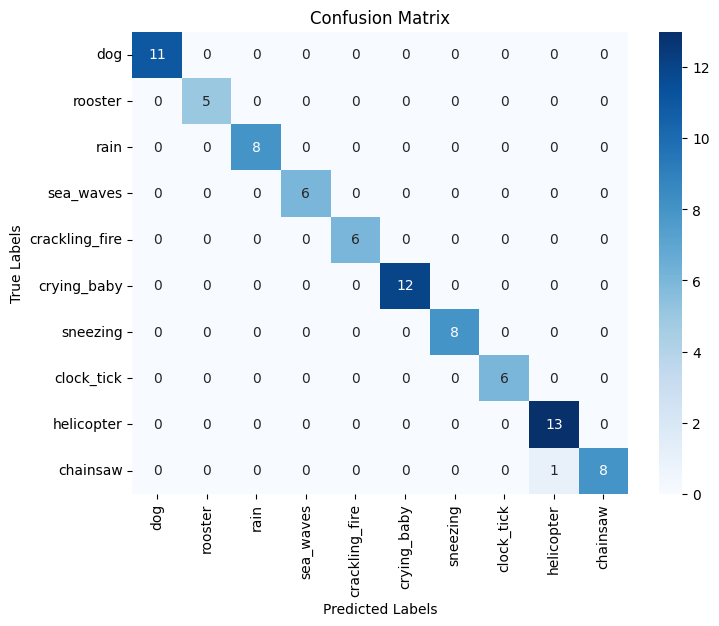


Classwise Analysis:
Class dog - Precision: 1.00, Recall: 1.00
Class rooster - Precision: 1.00, Recall: 1.00
Class rain - Precision: 1.00, Recall: 1.00
Class sea_waves - Precision: 1.00, Recall: 1.00
Class crackling_fire - Precision: 1.00, Recall: 1.00
Class crying_baby - Precision: 1.00, Recall: 1.00
Class sneezing - Precision: 1.00, Recall: 1.00
Class clock_tick - Precision: 1.00, Recall: 1.00
Class helicopter - Precision: 0.93, Recall: 1.00
Class chainsaw - Precision: 1.00, Recall: 0.89


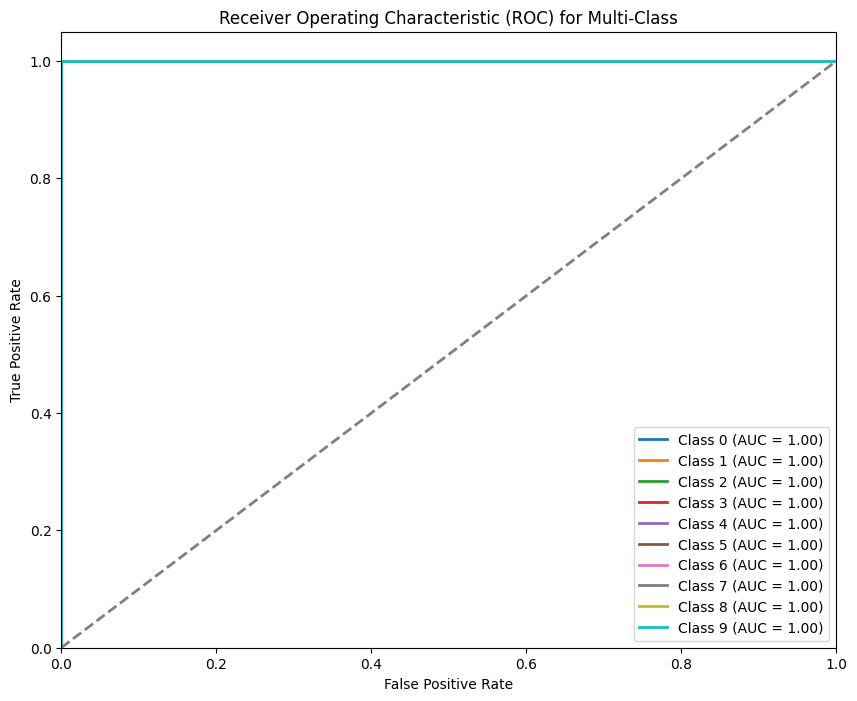

In [17]:
ESC_10 = True
_, test_loader,inverse_map = get_dataloaders(ESC_10)

model = ESC_AST(num_classes=10)
model.to(DEVICE)

best_model_path = os.path.join(BASE_MODEL_PATH,'trained_ast_esc10.pth')
model.load_model(best_model_path)

_=test(model,test_loader,inverse_map,DEVICE,plot=True, testMode=True)

#### ESC50

Train Data Insights
Number of Entries: 1600
Number of Classes: 50
Number of Folds: 5
Number of Entries per Fold:
	 1 320
	 2 320
	 3 320
	 4 320
	 5 320

Test Data Insights
Number of Entries: 400
Number of Classes: 50
Number of Folds: 5
Number of Entries per Fold:
	 1 80
	 2 80
	 3 80
	 4 80
	 5 80
Model weights loaded successfully from: /content/drive/MyDrive/Freelance/ESC_50/models/trained_ast_esc50.pth


Testing: 100%|█████████████████████████████| 50/50 [00:54<00:00,  1.10s/it, accuracy=Calculating...]



Test Accuracy: 96.50%
Precision: 0.97
Recall: 0.96
F1 Score: 0.97
ROC AUC: 1.00

Confusion Matrix:


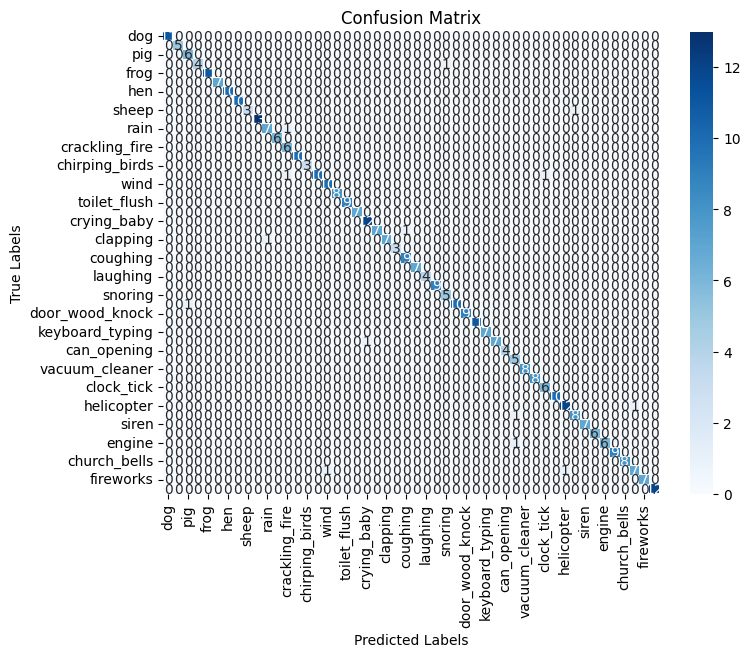


Classwise Analysis:
Class dog - Precision: 1.00, Recall: 1.00
Class rooster - Precision: 1.00, Recall: 1.00
Class pig - Precision: 0.86, Recall: 1.00
Class cow - Precision: 1.00, Recall: 0.80
Class frog - Precision: 1.00, Recall: 1.00
Class cat - Precision: 1.00, Recall: 1.00
Class hen - Precision: 1.00, Recall: 1.00
Class insects - Precision: 1.00, Recall: 1.00
Class sheep - Precision: 1.00, Recall: 0.75
Class crow - Precision: 1.00, Recall: 1.00
Class rain - Precision: 0.88, Recall: 0.88
Class sea_waves - Precision: 1.00, Recall: 1.00
Class crackling_fire - Precision: 0.75, Recall: 1.00
Class crickets - Precision: 1.00, Recall: 1.00
Class chirping_birds - Precision: 1.00, Recall: 1.00
Class water_drops - Precision: 1.00, Recall: 0.83
Class wind - Precision: 0.91, Recall: 1.00
Class pouring_water - Precision: 1.00, Recall: 1.00
Class toilet_flush - Precision: 1.00, Recall: 1.00
Class thunderstorm - Precision: 1.00, Recall: 1.00
Class crying_baby - Precision: 0.92, Recall: 1.00
Class 

In [18]:
ESC_10 = False
_, test_loader,inverse_map = get_dataloaders(ESC_10)


model = ESC_AST(num_classes=50)
model.to(DEVICE)
best_model_path = os.path.join(BASE_MODEL_PATH,'trained_ast_esc50.pth')
model.load_model(best_model_path)

_=test(model,test_loader,inverse_map,DEVICE,plot=False, testMode=True)